In [1]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
import joblib

from trainning import store_model

class Classifiers(object):

    def __init__(self,train_data,train_labels,hyperTune=True):
        self.train_data=train_data
        self.train_labels=train_labels
        self.construct_all_models(hyperTune)

    def store_model(self, model, model_name = ""):
        # NOTE: sklearn.joblib faster than pickle of Python
        # INFO: can store only ONE object in a file
        if model_name == "": 
            model_name = type(model).__name__
        joblib.dump(model,'models/' + model_name + '_model.pkl')
    
    def construct_all_models(self,hyperTune):
        if hyperTune:
            #3 models KNN SCM and LR
            self.models={'SVM':[SVC(kernel='linear',probability=True),dict(C=np.arange(0.01, 2.01, 0.2))],\
                         'LogisticRegression':[lr(),dict(C=np.arange(0.1,3,0.1))],\
                         'KNN':[KNeighborsClassifier(),dict(n_neighbors=range(1, 100))],}
            for name,candidate_hyperParam in self.models.items():
                #update each classifier after training and tuning
                self.models[name] = self.train_with_hyperParamTuning(candidate_hyperParam[0],name,candidate_hyperParam[1])
            print ('\nTraining process finished\n\n\n')

    def train_with_hyperParamTuning(self,model,name,param_grid):
        #grid search method for hyper-parameter tuning
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
        grid.fit(self.train_data, self.train_labels)
        joblib.dump(grid,'saved_objects/' + name  + '_gridsearch.pkl')
        self.store_model(grid, name)
        
        print(
            '\nThe best hyper-parameter for -- {} is {}, the corresponding mean accuracy through 10 Fold test is {} \n'\
            .format(name, grid.best_params_, grid.best_score_))

        model = grid.best_estimator_
        train_pred = model.predict(self.train_data)
        print('{} train accuracy = {}\n'.format(name,(train_pred == self.train_labels).mean()))
        return model

    def prediction_metrics(self,test_data,test_labels,name):

        #accuracy
        print('{} test accuracy = {}\n'.format(name,(self.models[name].predict(test_data) == test_labels).mean()))

        #AUC of ROC
        prob = self.models[name].predict_proba(test_data)
        auc=roc_auc_score(test_labels,prob[:,1])
        print('Classifier {} area under curve of ROC is {}\n'.format(name,auc))

        #ROC
        fpr, tpr, thresholds = roc_curve(test_labels, prob[:,1], pos_label=1)
        self.roc_plot(fpr,tpr,name,auc)

    def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()


____________ Dataset info ______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Columns: 601 entries, label to L149
dtypes: int64(600), object(1)
memory usage: 488.4+ KB
None

____________ Some first data examples __________________
  label   X0   Y0   W0   L0   X1   Y1   W1   L1   X2  ...  W147  L147  X148  \
0     T  243  145  186  186  244  145  184  184  244  ...   183   183   246   
1     T  242  158  181  181  239  157  183  183  238  ...   177   177   246   
2     T  248  166  175  175  248  165  176  176  244  ...   183   183   240   

   Y148  W148  L148  X149  Y149  W149  L149  
0   145   186   186   247   147   185   185  
1   162   176   176   245   162   177   177  
2   160   181   181   242   161   181   181  

[3 rows x 601 columns]

____________ Counts on a feature _______________________
T    55
F    49
Name: label, dtype: int64

____________ Statistics of numeric features ____________
               X0          Y0     

c:\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
ht

In [7]:
import pandas as pd
raw_data = pd.read_csv('trainning_data.csv')

In [3]:
#"label", "phone", "student name", "id", "date", "ip", "model"
import pandas as pd
raw_data = pd.read_csv('exam_data.csv')
select_columns = raw_data[["label", "id", "student name", "ip", "phone", "date", "model"]]
select_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         40 non-null     object
 1   id            40 non-null     object
 2   student name  40 non-null     object
 3   ip            40 non-null     object
 4   phone         26 non-null     object
 5   date          40 non-null     object
 6   model         23 non-null     object
dtypes: object(7)
memory usage: 2.3+ KB


In [35]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.50, random_state=42) # set random_state to get the same training set all the time, 

train_set_labels = train_set["label"].copy()
train_set = train_set.drop(columns = "label") 
test_set_labels = test_set["label"].copy()
test_set = test_set.drop(columns = "label") 

In [36]:
classifiers = Classifiers(train_set,train_set_labels)


The best hyper-parameter for -- SVM is {'C': 0.01}, the corresponding mean accuracy through 10 Fold test is 0.64 

SVM train accuracy = 1.0



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



The best hyper-parameter for -- LogisticRegression is {'C': 0.1}, the corresponding mean accuracy through 10 Fold test is 0.6566666666666666 

LogisticRegression train accuracy = 1.0


The best hyper-parameter for -- KNN is {'n_neighbors': 2}, the corresponding mean accuracy through 10 Fold test is 0.8266666666666665 

KNN train accuracy = 0.9423076923076923


Training process finished





c:\Python310\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.73333333 0.82666667 0.69333333 0.71333333 0.69333333 0.71333333
 0.71       0.75       0.71333333 0.73       0.69333333 0.71333333
 0.67333333 0.67333333 0.67333333 0.67333333 0.65333333 0.65333333
 0.61333333 0.63333333 0.61333333 0.63333333 0.58       0.58
 0.56       0.58       0.56       0.56       0.56       0.56
 0.56       0.56       0.56       0.56       0.56       0.56
 0.56       0.56       0.56       0.56       0.56       0.56
 0.56       0.56       0.56       0.56              nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan

In [ ]:
for name,candidate_hyperParam in classifiers.models.items():
  print(candidate_hyperParam)

KNN test accuracy = 0.6923076923076923

Classifier KNN area under curve of ROC is 0.7662721893491125



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


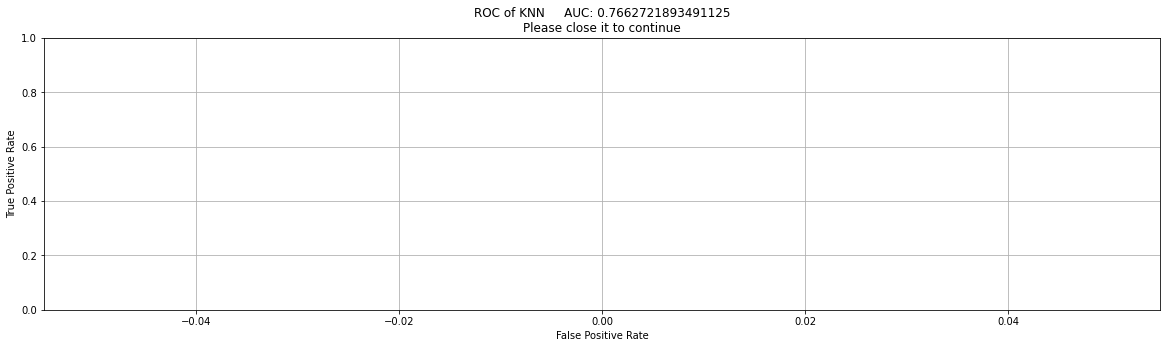

In [37]:
classifiers.prediction_metrics(test_set, test_set_labels, 'KNN')

LogisticRegression test accuracy = 0.7307692307692307

Classifier LogisticRegression area under curve of ROC is 0.7174556213017752



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


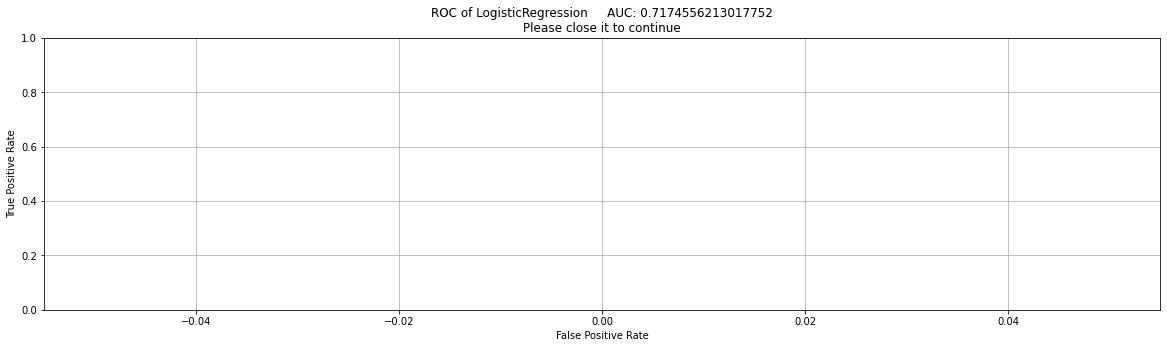

In [38]:
classifiers.prediction_metrics(test_set, test_set_labels, 'LogisticRegression')

SVM test accuracy = 0.7307692307692307

Classifier SVM area under curve of ROC is 0.7381656804733727



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


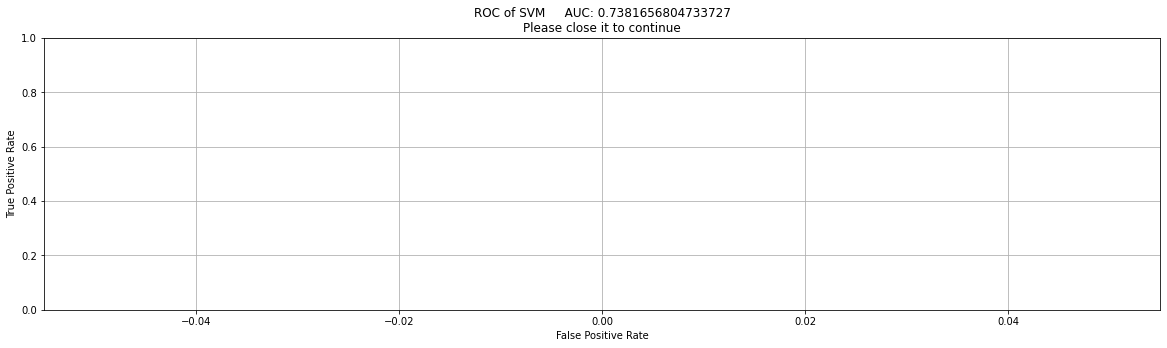

In [39]:
classifiers.prediction_metrics(test_set, test_set_labels, 'SVM')

In [11]:
name = 'LogisticRegression'
print('{} test accuracy = {}\n'.format(name,(classifiers.models[name].predict(test_set) == test_set_labels).mean()))
prob = classifiers.models[name].predict_proba(test_set)


LogisticRegression test accuracy = 0.6666666666666666



In [ ]:
auc = roc_auc_score(test_set_labels, prob[:,1])
print('Classifier {} area under curve of ROC is {}\n'.format(name,auc))

fpr, tpr, thresholds = roc_curve(test_set_labels, prob[:,1], pos_label=1)

In [ ]:
def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()

In [ ]:
classifiers.roc_plot(fpr, tpr, name, auc)